<a href="https://colab.research.google.com/github/kvijay0611/CNN_Pytorch_Learn/blob/main/Brain_MRI_model_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
from torch import nn

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get Data

In [10]:
import requests
import zipfile
from pathlib import Path


In [11]:
!pip install kagglehub

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
! mkdir ~/.kaggle

In [14]:
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/


In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 139M/149M [00:01<00:00, 110MB/s]
100% 149M/149M [00:01<00:00, 137MB/s]


In [17]:
!unzip brain-tumor-mri-dataset.zip -d Brain_tumor

Streaming output truncated to the last 5000 lines.
  inflating: Brain_tumor/Training/glioma/Tr-gl_0712.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0713.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0714.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0715.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0716.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0717.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0718.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0719.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0720.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0721.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0722.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0723.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0724.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0725.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0726.jpg  
  inflating: Brain_tumor/Training/glioma/Tr-gl_0727.jpg  
  inflating: Brain_tu

# Data Preparation

In [18]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [19]:
walk_through_dir("Brain_tumor")

There are 2 directories and 0 images in 'Brain_tumor'.
There are 4 directories and 0 images in 'Brain_tumor/Training'.
There are 0 directories and 1339 images in 'Brain_tumor/Training/meningioma'.
There are 0 directories and 1321 images in 'Brain_tumor/Training/glioma'.
There are 0 directories and 1457 images in 'Brain_tumor/Training/pituitary'.
There are 0 directories and 1595 images in 'Brain_tumor/Training/notumor'.
There are 4 directories and 0 images in 'Brain_tumor/Testing'.
There are 0 directories and 306 images in 'Brain_tumor/Testing/meningioma'.
There are 0 directories and 300 images in 'Brain_tumor/Testing/glioma'.
There are 0 directories and 300 images in 'Brain_tumor/Testing/pituitary'.
There are 0 directories and 405 images in 'Brain_tumor/Testing/notumor'.


In [20]:
train_dir = "/content/Brain_tumor/Training"
test_dir = "/content/Brain_tumor/Testing"

train_dir, test_dir

('/content/Brain_tumor/Training', '/content/Brain_tumor/Testing')

In [21]:
import os
print(os.getcwd()) # print the current working directory
print(os.listdir()) # print the contents of the current working directory
print(os.path.exists(train_dir)) # check if the train_dir exists

/content
['.config', 'Brain_tumor', 'data', 'drive', 'brain-tumor-mri-dataset.zip', 'sample_data']
True


Visualizing the Image

In [22]:
#/content/Brain_tumor

Random image path: /content/Brain_tumor/Training/glioma/Tr-gl_0376.jpg
Image class: glioma
Image size: (512, 512)
Image height: 512
Image width: 512


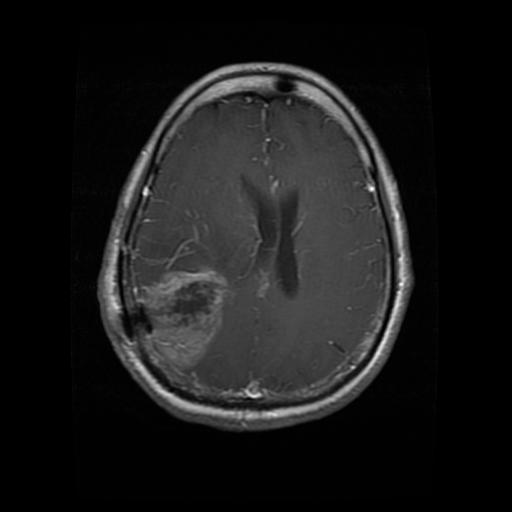

In [23]:
import random
from PIL import Image

#random.seed(42)
image_path = Path("/content/Brain_tumor")
image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(len(image_path_list))

random_image_path = random.choice(image_path_list)
# print(random_image_path.parent.stem)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image size: {img.size}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

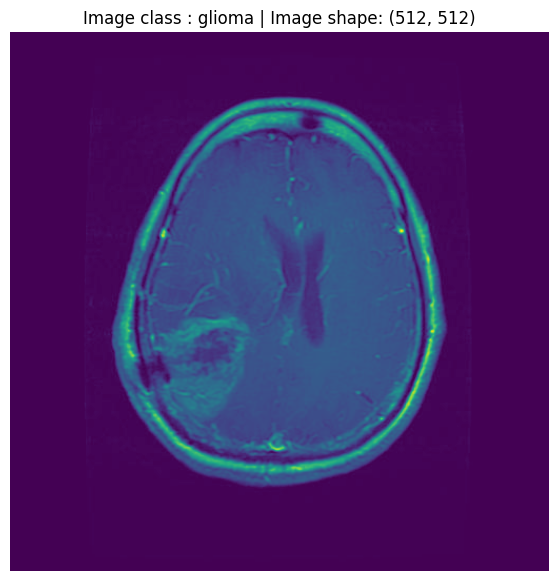

In [24]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

#ploting
plt.figure(figsize= (10,7))
plt.imshow(img_as_array)

plt.title(f"Image class : {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## Converting them to Tensosrs

In [25]:
#Transformation of Data
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [26]:
data_transform = transforms.Compose([

    transforms.Resize(size= (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

In [27]:
data_transform(img).dtype

torch.float32

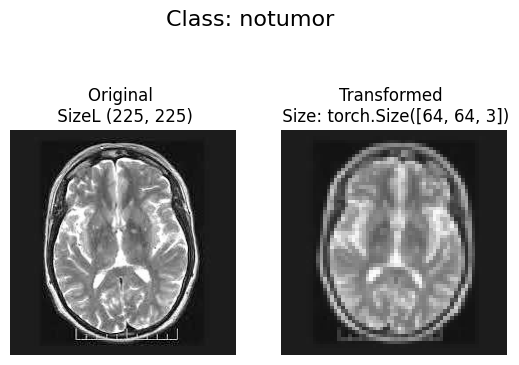

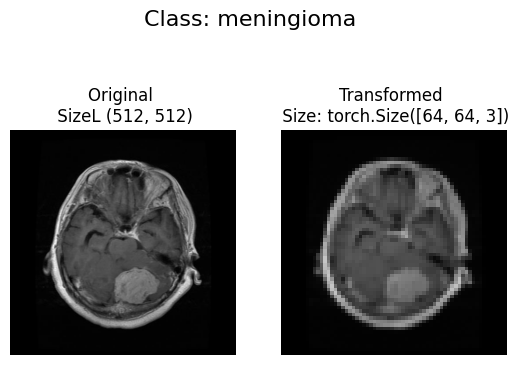

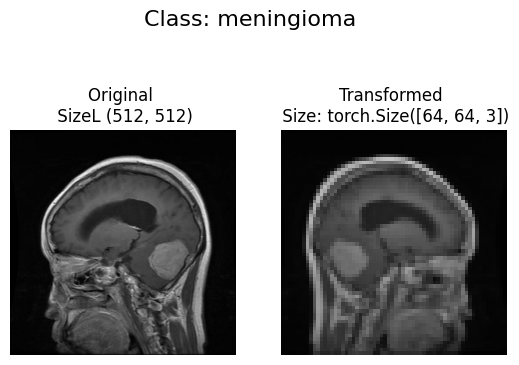

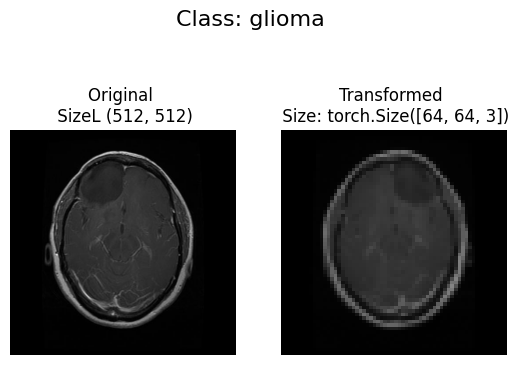

In [28]:
def plot_transformed_images(image_path: list, transform, n=4, seed=42):

  if seed:
    random.seed(seed)
    random_image_path = random.sample(image_path, k=n)
    for image_path in random_image_path:
      with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \n SizeL {f.size}")
        ax[0].axis("off")


        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform = data_transform, n=4)





In [29]:
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir, transform= data_transform,
                                  target_transform= None)

test_data = datasets.ImageFolder(root= test_dir, transform= data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5712
     Root location: /content/Brain_tumor/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1311
     Root location: /content/Brain_tumor/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [30]:
test_dir , train_dir

('/content/Brain_tumor/Testing', '/content/Brain_tumor/Training')

In [31]:
class_names = train_data.classes
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [32]:
#Index on train data
img , label = train_data[0][0], train_data[0][1]
print(f"Image tensor :/n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"label datatype: {type(label)}")

Image tensor :/ntensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'glioma')

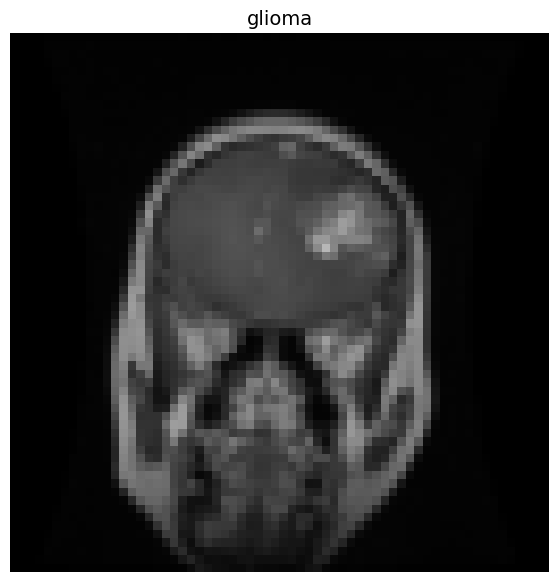

In [33]:
#Rearrange the dimensions
img_permute =img.permute(1, 2, 0)

print(f"Original shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

Turn loaded images into Dataloaders

In [34]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset= train_data, batch_size= BATCH_SIZE,
                              num_workers = 1,
                              shuffle= True)
test_dataloader = DataLoader(dataset = test_data, batch_size= BATCH_SIZE,
                             num_workers= 1, shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ef0daf4c280>,
 <torch.utils.data.dataloader.DataLoader at 0x7ef0db5458d0>)

In [35]:
len(train_dataloader), len(test_dataloader)

(179, 41)

## Augumentation of Data

In [36]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size= (244, 244)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size= (244, 244)),
    transforms.ToTensor()
])

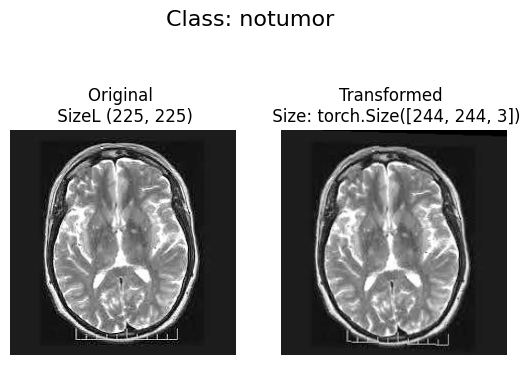

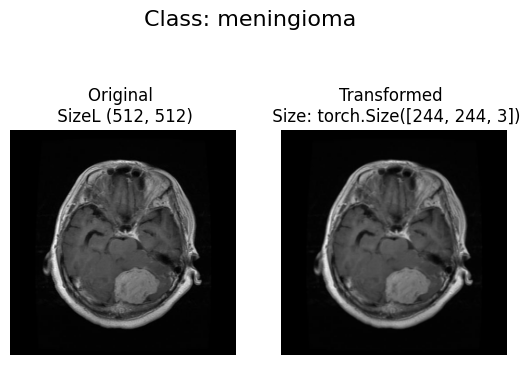

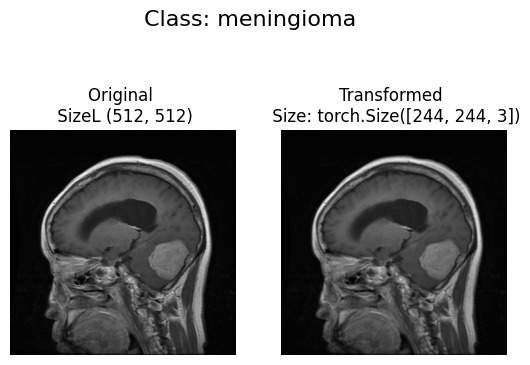

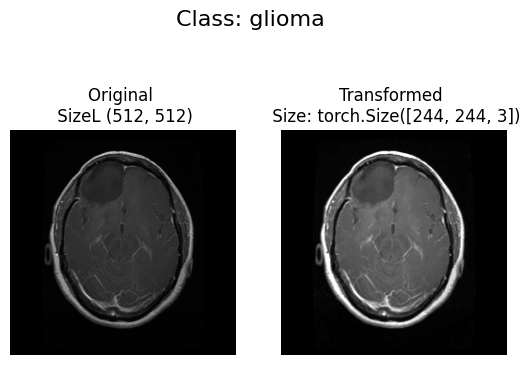

In [37]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(image_path= image_path_list, transform= train_transform,
                        n = 4, seed= 42)

# Model 0: Tiny VGG without data augmentation

In [38]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int,
              hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3, stride= 1, padding= 0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units,
                  kernel_size= 3, stride= 1, padding= 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2, )

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size= 3,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size= 3,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*13*13,
                  out_features= output_shape)

    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x =self.classifier(x)
    # print(x.shape)
    return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape= 3,
                  hidden_units = 10,
                  output_shape= len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

Testing model by  doing forward pass w single img

In [39]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [40]:
#forward pass
model_0(image_batch.to(device))

tensor([[-0.0041,  0.0207,  0.0443, -0.0141],
        [-0.0044,  0.0223,  0.0435, -0.0145],
        [-0.0066,  0.0242,  0.0434, -0.0145],
        [-0.0051,  0.0214,  0.0449, -0.0156],
        [-0.0053,  0.0218,  0.0429, -0.0154],
        [-0.0057,  0.0232,  0.0446, -0.0142],
        [-0.0032,  0.0216,  0.0447, -0.0137],
        [-0.0059,  0.0216,  0.0453, -0.0151],
        [-0.0030,  0.0219,  0.0449, -0.0144],
        [-0.0047,  0.0216,  0.0433, -0.0149],
        [-0.0052,  0.0223,  0.0450, -0.0156],
        [-0.0042,  0.0222,  0.0438, -0.0145],
        [-0.0046,  0.0215,  0.0406, -0.0147],
        [-0.0054,  0.0238,  0.0435, -0.0156],
        [-0.0055,  0.0245,  0.0437, -0.0142],
        [-0.0053,  0.0231,  0.0443, -0.0153],
        [-0.0059,  0.0216,  0.0448, -0.0133],
        [-0.0056,  0.0221,  0.0455, -0.0148],
        [-0.0051,  0.0225,  0.0441, -0.0151],
        [-0.0052,  0.0230,  0.0439, -0.0144],
        [-0.0056,  0.0215,  0.0441, -0.0152],
        [-0.0028,  0.0218,  0.0443

to get idea of the shapes going through our model

In [41]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size= [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [42]:
#Train
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [43]:
#Test
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Setting Loss and Optim

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Combine Train and Test

In [45]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps

    # 2. Create empty results dictionary
results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
epochs=26

    # 3. Loop through training and testing steps for a number of epochs
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
    test_loss, test_acc = test_step(model=model_0,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
    if epoch % 5 == 0:
      print(f"Epoch: {epoch} | "f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}" )



        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
print(results)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.9725 | train_acc: 0.5925 | test_loss: 0.9729 | test_acc: 0.6798
Epoch: 5 | train_loss: 0.4372 | train_acc: 0.8411 | test_loss: 0.5425 | test_acc: 0.8071
Epoch: 10 | train_loss: 0.3532 | train_acc: 0.8710 | test_loss: 0.4727 | test_acc: 0.8415
Epoch: 15 | train_loss: 0.2977 | train_acc: 0.8912 | test_loss: 0.4011 | test_acc: 0.8498
Epoch: 20 | train_loss: 0.2411 | train_acc: 0.9120 | test_loss: 0.3126 | test_acc: 0.8841
Epoch: 25 | train_loss: 0.2015 | train_acc: 0.9282 | test_loss: 0.3572 | test_acc: 0.8819
{'train_loss': [0.9724505988246236, 0.6116721552676995, 0.5312696041008613, 0.48886684141012543, 0.45124503395743876, 0.4372148025135754, 0.4147018091805154, 0.4024494765690585, 0.38783913151511934, 0.37665085024174366, 0.3532344201506849, 0.3396758839238289, 0.3269669858936491, 0.31676651568635883, 0.3001861818051538, 0.297665175570789, 0.27554120144198063, 0.2784920813484565, 0.2727283240197091, 0.2543402921054616, 0.24114089049190782, 0.23389753345504152,

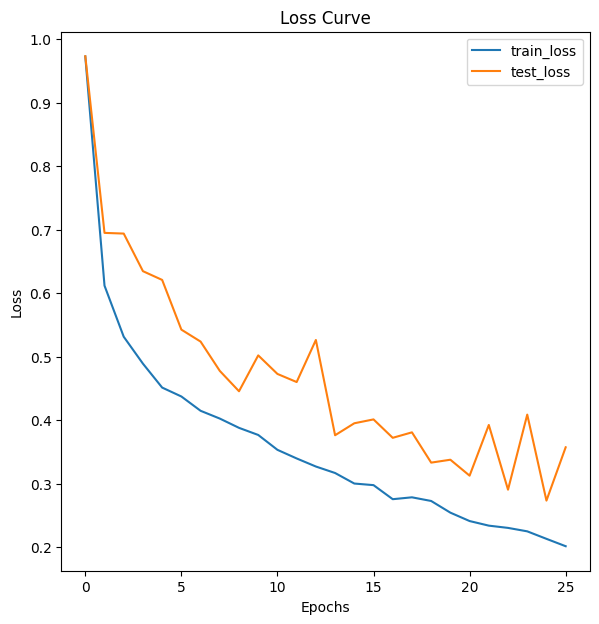

In [46]:
## Plotting Train and Test Loss
import matplotlib.pyplot as plt
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]
  epochs = range(len(train_loss))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label= "train_loss")
  plt.plot(epochs, test_loss, label= "test_loss")
  plt.title("Loss Curve")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(results)

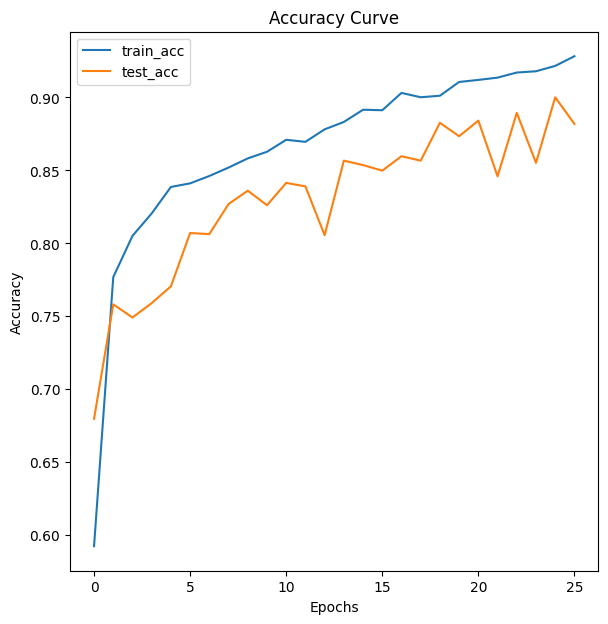

In [47]:
## Plotting Train and Test Accuracy
import matplotlib.pyplot as plt
def plot_acc_curves(results):
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]
  epochs = range(len(train_acc))
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label= "train_acc")
  plt.plot(epochs, test_acc, label= "test_acc")
  plt.title("Accuracy Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

plot_acc_curves(results)

# Test and Evaluate Model 0

In [48]:
## Evaluate model metrics
def eval_model(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()
  model_0_loss, model_0_acc = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      model_0_logits = model(X)
      loss = loss_fn(model_0_logits, y)
      model_0_loss += loss.item()

      model_0_pred_labels = torch.softmax(model_0_logits, dim=1).argmax(dim=1)

      model_0_acc += (model_0_pred_labels == y).sum().item()/len(model_0_pred_labels)
      #print(model_0_preds)
  model_0_loss = model_0_loss / len(dataloader)
  model_0_acc = model_0_acc / len(dataloader)
  return model_0_loss, model_0_acc

eval_model(model_0, test_dataloader, loss_fn)

(0.33429214862606876, 0.8864329268292683)

## Confusion Matrix, Predictions, Inferencing, Metrics

In [49]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.7 MB/s eta 0:00:00


In [50]:
import mlxtend
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


In [51]:
def make_predictions(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    y_preds = []
    y_true = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probabilities and predicted labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            # Collect predictions and true labels
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    # Combine all predictions and true labels into tensors
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


Train Data Metrics and CM

In [52]:
y_preds_train,y_true_train=make_predictions(model=model_0,
                 dataloader=train_dataloader)

Making predictions...: 100%|██████████| 179/179 [00:25<00:00,  6.98it/s]


In [53]:
confmat = ConfusionMatrix(num_classes=len(train_data.classes),
                          task="multiclass")

confmat_tensor=confmat(preds=y_preds_train,target=y_true_train)


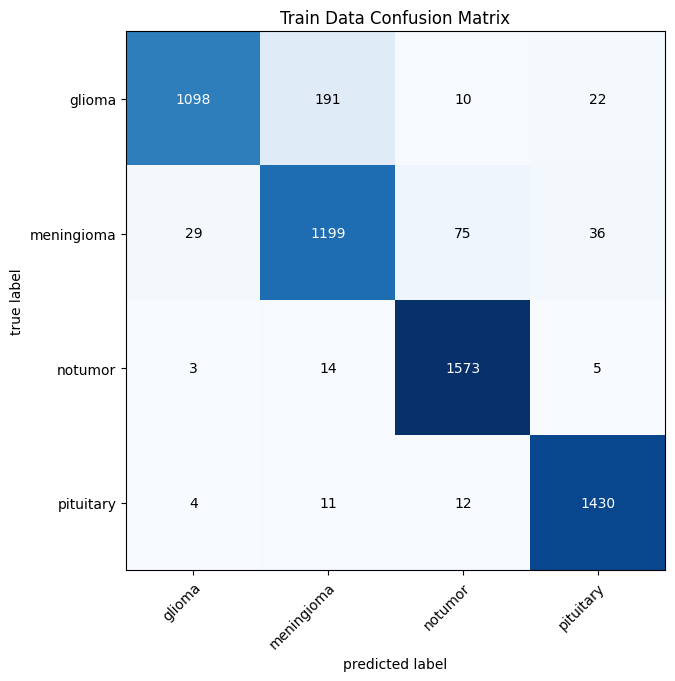

In [54]:
## Plot the confusion matrix

fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(10,7),
                           class_names=train_data.classes)
plt.title("Train Data Confusion Matrix")
plt.show()

In [55]:
## Metrics

precision = precision_score(y_true_train, y_preds_train, average='weighted')
recall = recall_score(y_true_train, y_preds_train, average='weighted')
f1 = f1_score(y_true_train, y_preds_train, average='weighted')
accuracy=accuracy_score(y_true_train, y_preds_train)

print(f"Precision for Training Data: {precision:.4f}")
print(f"Recall for Training Data: {recall:.4f}")
print(f"F1-score for Training Data: {f1:.4f}")
print(f"Accuracy for Training Data: {accuracy:.4f}")

Precision for Training Data: 0.9299
Recall for Training Data: 0.9279
F1-score for Training Data: 0.9273
Accuracy for Training Data: 0.9279


Test Data Metrics and CM

In [56]:
y_preds_test,y_true_test=make_predictions(model=model_0,
                 dataloader=test_dataloader)

Making predictions...: 100%|██████████| 41/41 [00:06<00:00,  6.27it/s]


In [57]:
confmat = ConfusionMatrix(num_classes=len(test_data.classes),
                          task="multiclass")

confmat_tensor=confmat(preds=y_preds_test,target=y_true_test)


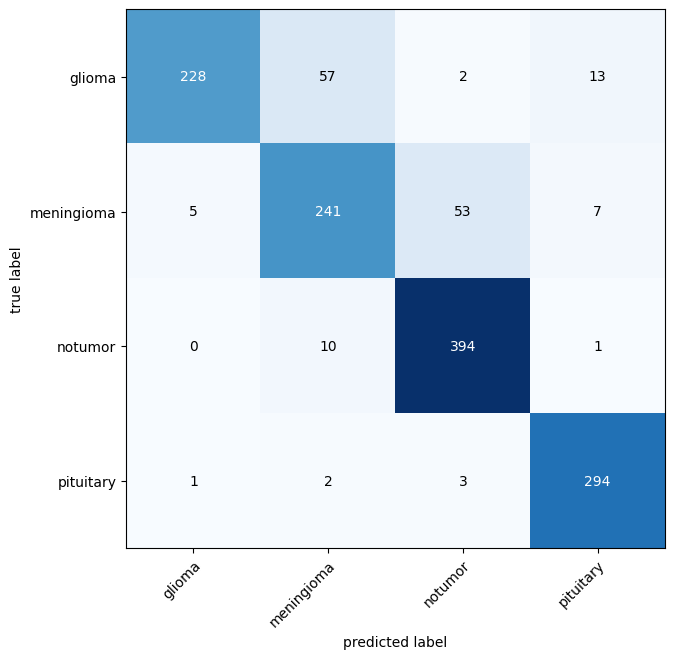

In [58]:
## Plot the confusion matrix

fig,ax=plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                           figsize=(10,7),
                           class_names=test_data.classes)
plt.show()

In [59]:
## Metrics

precision = precision_score(y_true_test, y_preds_test, average='weighted')
recall = recall_score(y_true_test, y_preds_test, average='weighted')
f1 = f1_score(y_true_test, y_preds_test, average='weighted')
accuracy=accuracy_score(y_true_test, y_preds_test)


print(f"Precision for Testing Data: {precision:.4f}")
print(f"Recall for Testing Data: {recall:.4f}")
print(f"F1-score for Testing Data: {f1:.4f}")
print(f"Accuracy for Training Data: {accuracy:.4f}")

Precision for Testing Data: 0.8873
Recall for Testing Data: 0.8825
F1-score for Testing Data: 0.8809
Accuracy for Training Data: 0.8825


# Making Custom Data Prediction

data/Mri_brain.jpg already exists, skipping download.


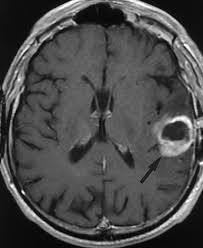

In [79]:
# You can get this by right clicking on the image at: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg
# And selecting "copy image address"
image_address = "https://github.com/kvijay0611/CNN_Pytorch_Learn/blob/main/images/Brain%20MRI%20scan.jpeg?raw=true"

# Download custom image
import requests
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
data_path.mkdir(exist_ok=True)

# Setup custom image path
custom_image_path = data_path / "Mri_brain.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(image_address) ### <- CHANGED
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Display image
from IPython.display import Image, display

display(Image(custom_image_path))

In [80]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[19, 19, 18,  ..., 16, 16, 16],
         [19, 19, 18,  ..., 15, 16, 16],
         [19, 19, 18,  ..., 15, 15, 16],
         ...,
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13]],

        [[19, 19, 18,  ..., 16, 16, 16],
         [19, 19, 18,  ..., 15, 16, 16],
         [19, 19, 18,  ..., 15, 15, 16],
         ...,
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13]],

        [[19, 19, 18,  ..., 16, 16, 16],
         [19, 19, 18,  ..., 15, 16, 16],
         [19, 19, 18,  ..., 15, 15, 16],
         ...,
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13],
         [15, 15, 15,  ..., 12, 12, 13]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 248, 203])

Custom image dtype: torch.uint8


In [81]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.0745, 0.0745, 0.0706,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..., 0.0588, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..., 0.0588, 0.0588, 0.0627],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510]],

        [[0.0745, 0.0745, 0.0706,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..., 0.0588, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..., 0.0588, 0.0588, 0.0627],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0510]],

        [[0.0745, 0.0745, 0.0706,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..., 0.0588, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0706,  ..

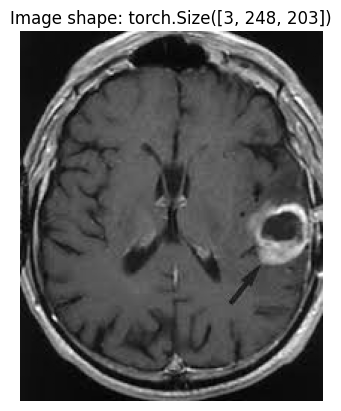

In [82]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [83]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 248, 203])
New shape: torch.Size([3, 64, 64])


In [84]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [85]:
custom_image_pred

tensor([[-10.3183,   1.7185,  -1.3607,  -1.7540]])

In [86]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-10.3183,   1.7185,  -1.3607,  -1.7540]])
Prediction probabilities: tensor([[5.4981e-06, 9.2847e-01, 4.2703e-02, 2.8819e-02]])
Prediction label: tensor([1])


In [87]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'meningioma'

## Saving the Model (Runtime Memory)

In [88]:
os.makedirs(os.path.join(os.getcwd(),"models"),exist_ok=True)
MODEL_NAME="Brain_CNN.pt"
MODEL_PATH=os.path.join(os.getcwd(),"models",MODEL_NAME)

In [89]:
print(f"Saving model to: {MODEL_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_PATH)

Saving model to: /content/models/Brain_CNN.pt


## Loading the Model

In [95]:
loaded_model = TinyVGG(input_shape= 3,
                  hidden_units = 10,
                  output_shape= len(train_data.classes)).to(device)

In [96]:
loaded_model.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>

In [97]:
## Check if all good by inferencing
eval_model(loaded_model, test_dataloader, loss_fn)

(0.3259673153572693, 0.8887195121951219)